In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor

%matplotlib inline

Read data drom file 'car_price.csv'

In [4]:
df = pd.read_csv('car_price.csv')
df.head()

,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [5]:
df.shape

(5512, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           5512 non-null   int64 
 1   car_name             5512 non-null   object
 2   car_prices_in_rupee  5512 non-null   object
 3   kms_driven           5512 non-null   object
 4   fuel_type            5512 non-null   object
 5   transmission         5512 non-null   object
 6   ownership            5512 non-null   object
 7   manufacture          5512 non-null   int64 
 8   engine               5512 non-null   object
 9   Seats                5512 non-null   object
dtypes: int64(2), object(8)
memory usage: 430.8+ KB


Data cleanup.
1. Every column has only non-null values - no need to delete null values
2. Drop columns 'Unnamed: 0' and 'car_name' - this informarion isn't useful


In [7]:
#Dropping columns 'Unnamed: 0' and 'car_name'
to_drop = ['Unnamed: 0','car_name']
df.drop(to_drop, inplace=True, axis=1)

Dropping duplicates

In [8]:
dups = df.duplicated()
print('Has duplicates: ', dups.any())
#print(df[dups])

#There are duplicates int the dataset => dropping duplicates
df.drop_duplicates(inplace=True)
print(df.shape)

Has duplicates:  True
(5435, 8)


Cleaning the data

In [9]:
#'car_prices_in_rupee': Lakh - 10^5; Crore - 10^7;
# Most prices are in Lakh so we take it as a unit. (Prices in Crore are *100, prices without specification are in ruppe - / 10^5)
price_lakh = df['car_prices_in_rupee'].str.endswith(' Lakh') # True if prices in Lakh, False - everything else
price_crore = df['car_prices_in_rupee'].str.endswith(' Crore') # True if prices in Crore, False - everything else
price_rupee = ~ price_lakh & ~ price_crore # True if prices in rupee, False - everything else

extr_price = df['car_prices_in_rupee'].str.replace(' Lakh','')
extr_price = extr_price.str.replace(' Crore','')
extr_price = extr_price.str.replace(',','')
extr_price = (extr_price).astype(float)
df['car_prices_in_rupee']= extr_price
df['car_prices_in_rupee'].where(~ price_crore,lambda x: x*100,inplace = True)
df['car_prices_in_rupee'].where(~ price_rupee,lambda x: x/(10**5),inplace = True)



# 'kms_driven' : deleting ' kms' at the end, changing type to numeric
extr_kms = df['kms_driven'].str.replace(' kms','')
extr_kms = extr_kms.str.replace(',','')
df['kms_driven'] = extr_kms.astype(int)

#'fuel_type'
df['fuel_type'].where(df['fuel_type'].str.endswith('Petrol'),1,inplace = True)
df['fuel_type'].where(df['fuel_type'].str.endswith('Diesel'),2,inplace = True)
df['fuel_type'].where(df['fuel_type'].str.endswith('Cng'),3,inplace = True)
df['fuel_type'].where(df['fuel_type'].str.endswith('Lpg'),4,inplace = True)
df['fuel_type'].where(df['fuel_type'].str.endswith('Electric'),5,inplace = True)

# Cleaning up 'Seats' column: deleting ' seats' at the end, changing type to int
extr_seats = df['Seats'].str.replace(' Seats','')
df['Seats'] = extr_seats.astype(int)

# ownership
extr_owner = df['ownership'].str.replace('st Owner','')
extr_owner = extr_owner.str.replace('nd Owner','')
extr_owner = extr_owner.str.replace('rd Owner','')
extr_owner = extr_owner.str.replace('th Owner','')
df['ownership'] = extr_owner.astype(int)

#'transmission'
extr_transmission = df['transmission'] == 'Manual'
df['transmission'] = extr_transmission.astype(int)

#manufacture
df['manufacture'] = df['manufacture'].astype(int)

#engine - in cubic centimeters
extr_engine = df['engine'].str.replace(' cc','')
df['engine'] = extr_engine.astype(int)

df.head()

,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,10.03,86226,1,1,1,2017,1956,5
1,12.83,13248,2,0,1,2021,1330,5
2,16.40,60343,2,0,1,2016,2494,5
3,7.77,26696,2,0,1,2018,1199,5
4,5.15,69414,2,1,1,2016,1199,5


Data analysis

In [10]:
df.describe()

,car_prices_in_rupee,kms_driven,transmission,ownership,manufacture,engine,Seats
count,5435.000000,5435.000000,5435.000000,5435.000000,5435.000000,5435.000000,5435.000000
mean,11.514146,63343.235511,0.720883,1.424655,2015.437902,1532.850046,5.252254
std,19.532349,41965.273993,0.448606,0.705400,3.938565,580.959278,0.722574
min,0.350000,250.000000,0.000000,0.000000,1995.000000,0.000000,2.000000
25%,3.130000,33233.000000,0.000000,1.000000,2013.000000,1197.000000,5.000000
50%,5.500000,59290.000000,1.000000,1.000000,2016.000000,1396.000000,5.000000
75%,10.205000,84380.000000,1.000000,2.000000,2018.000000,1950.000000,5.000000
max,192.000000,560000.000000,1.000000,5.000000,2022.000000,5950.000000,8.000000


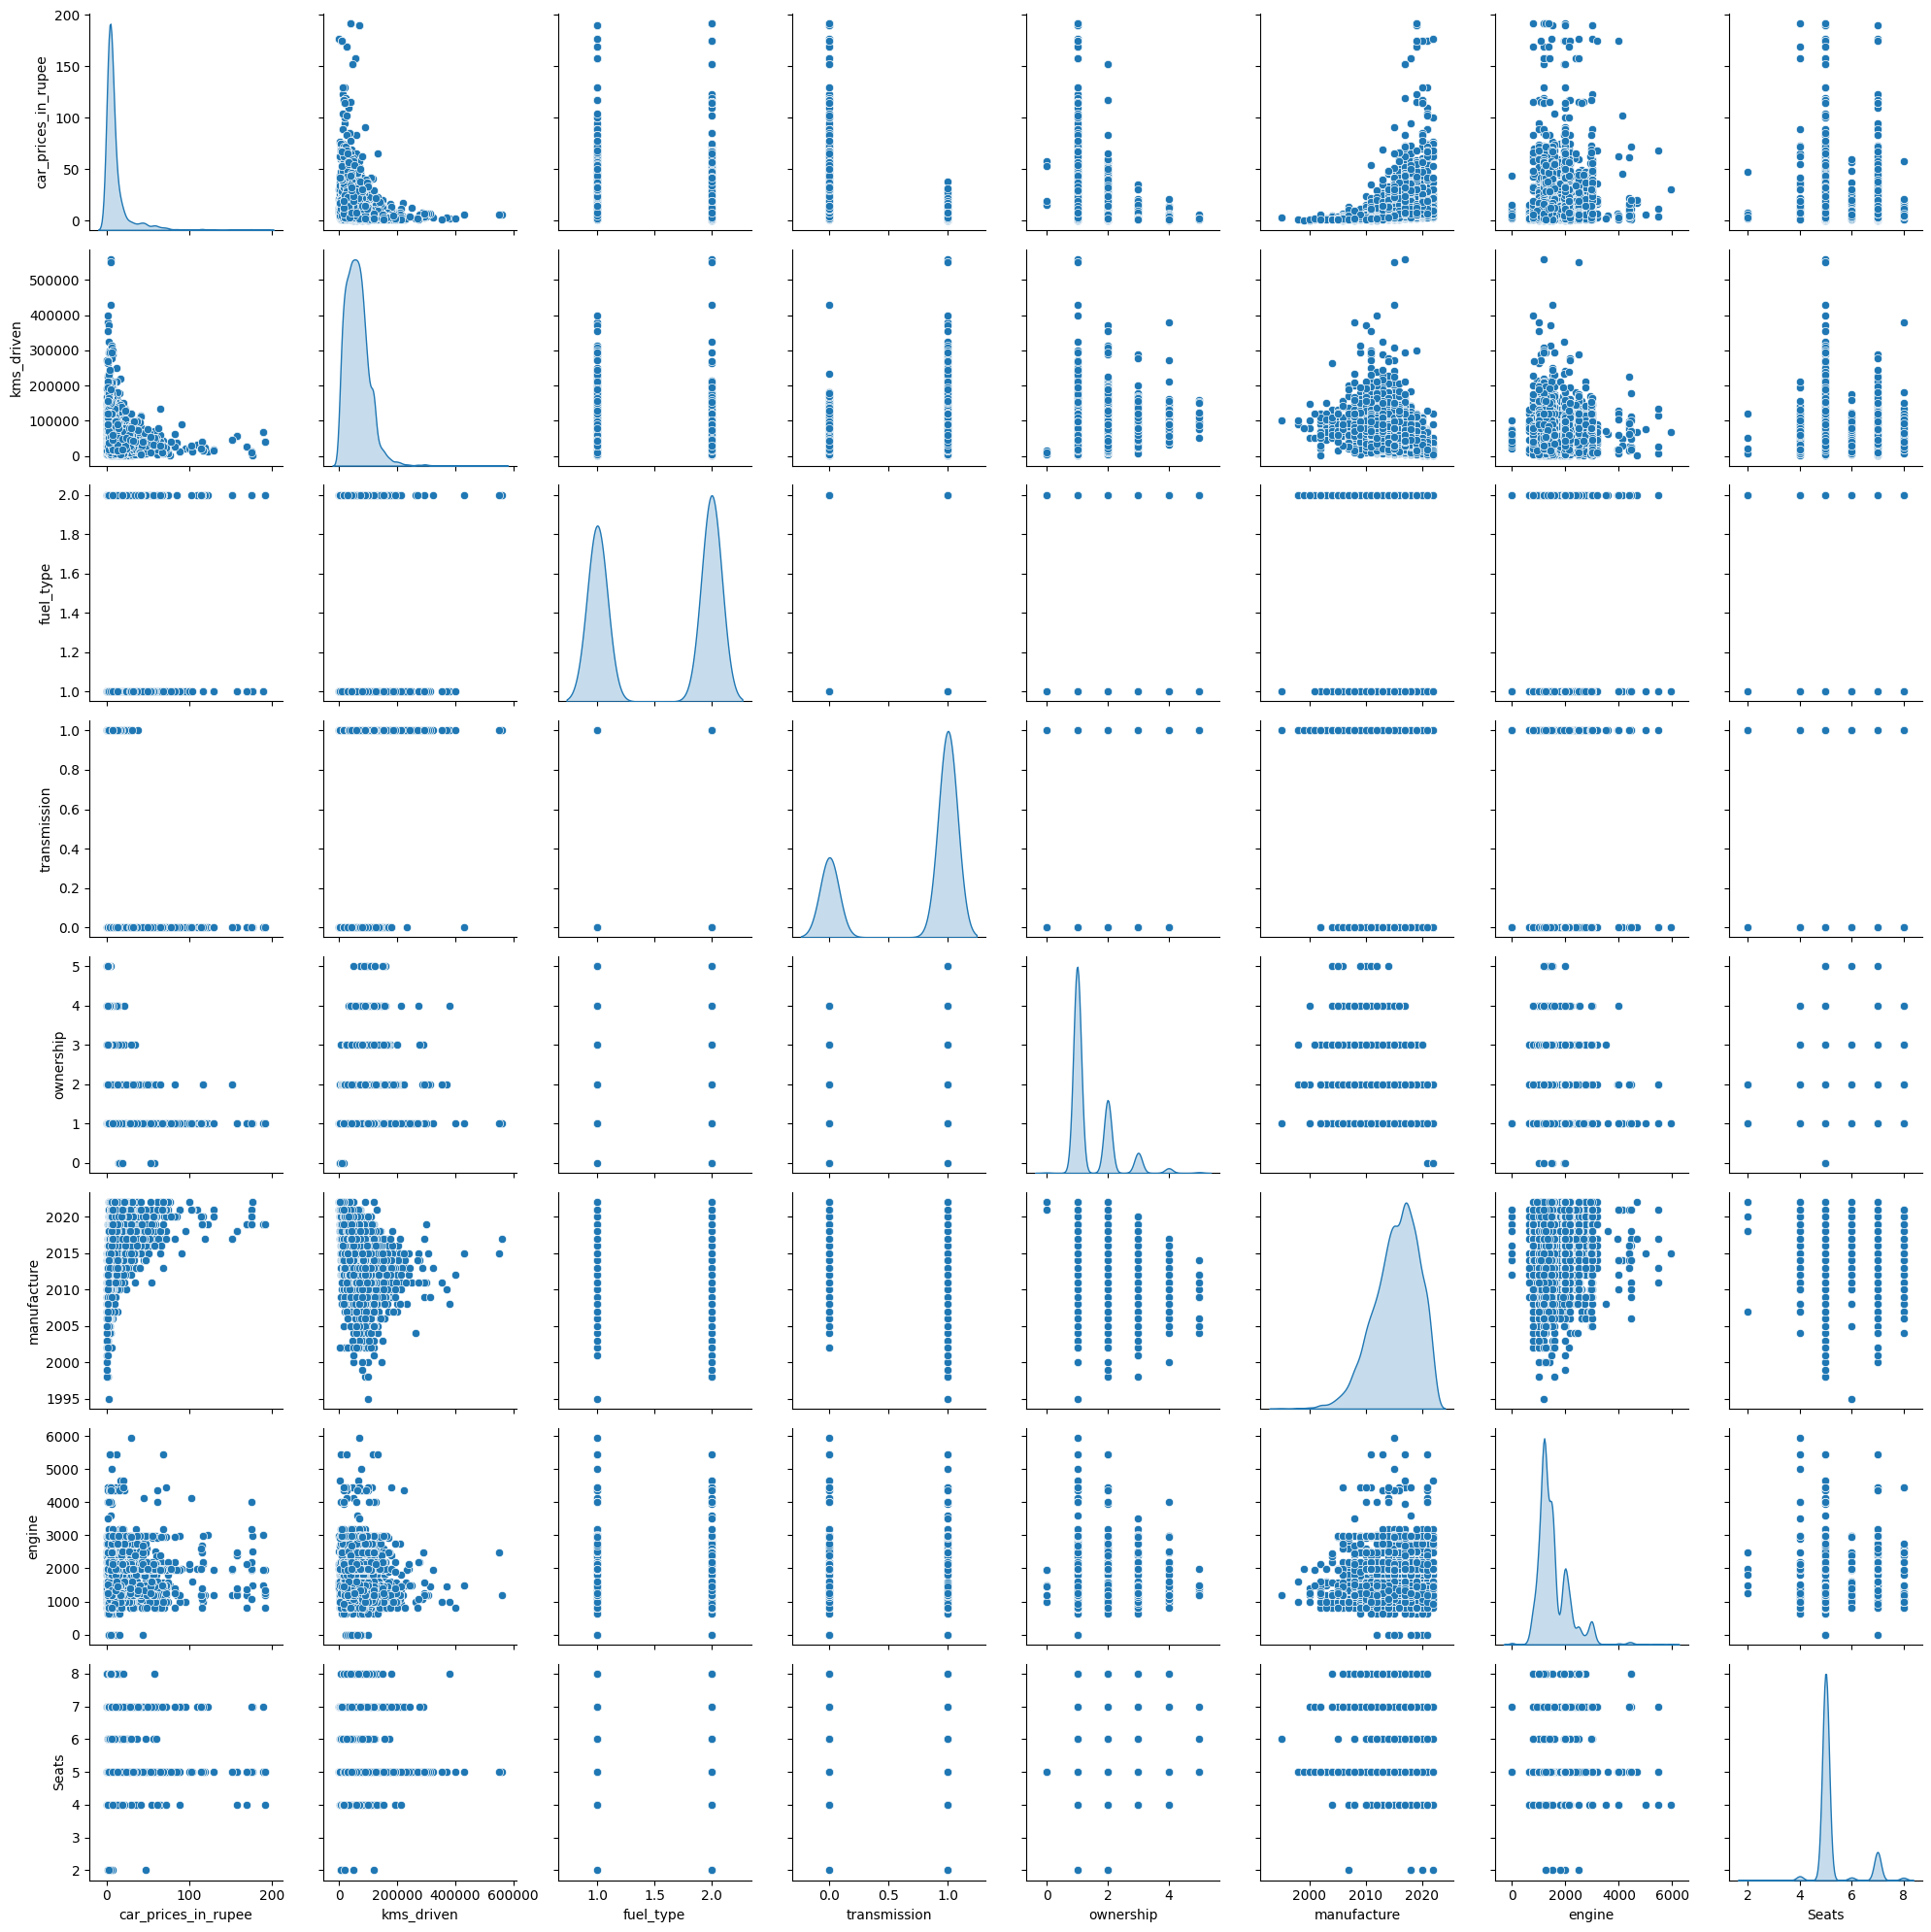

In [11]:
cols = ['car_prices_in_rupee','kms_driven', 'fuel_type','transmission', 'ownership', 'manufacture', 'engine', 'Seats']

sns.pairplot(df[cols],diag_kind='kde')
plt.tight_layout()
plt.show()

Histograms

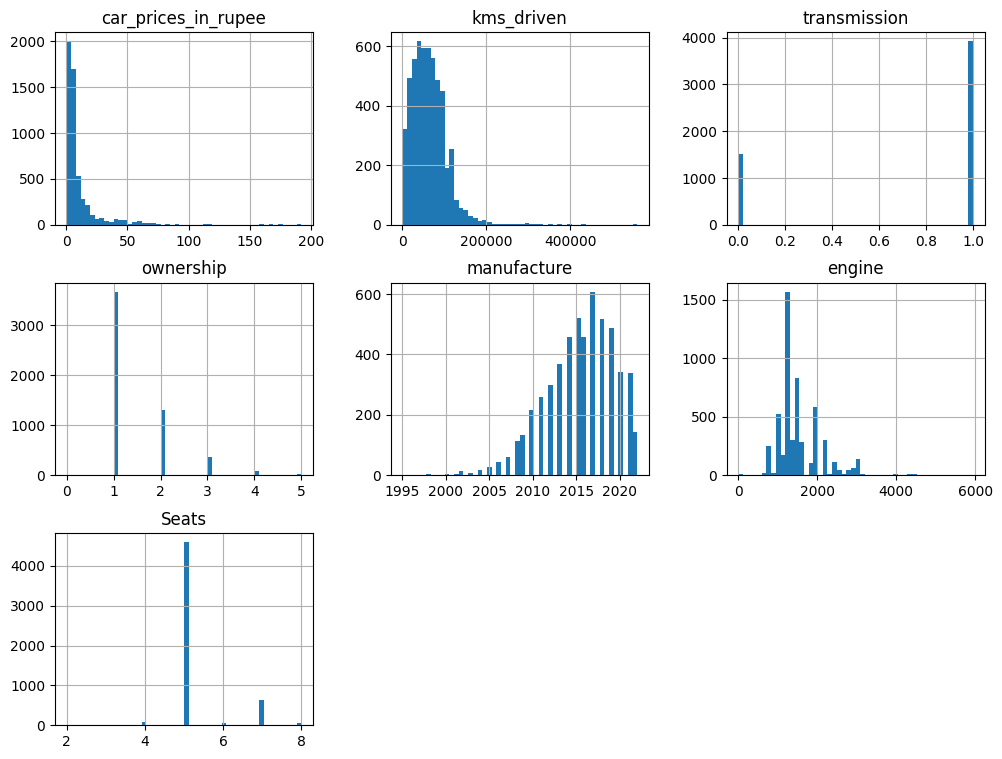

In [12]:
df.hist(bins = 50,figsize = (12,9))
plt.show()

Correlations

C:\Users\kate2\AppData\Local\Temp\ipykernel_6188\2276483110.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm = df[cols].corr()


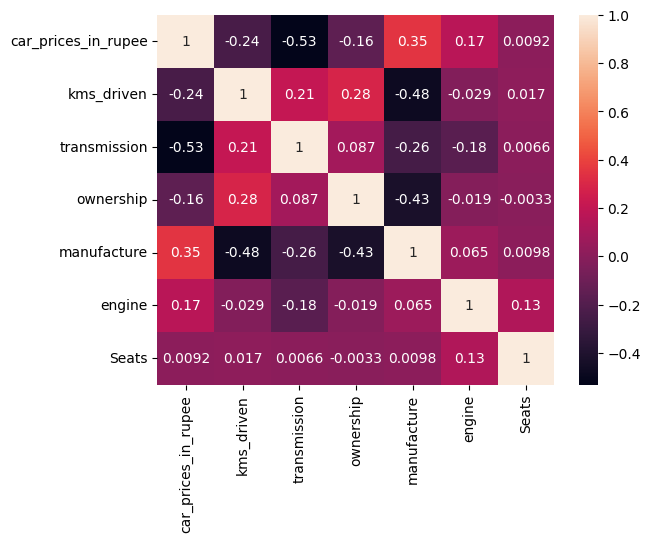

In [13]:
cm = df[cols].corr()

hm = sns.heatmap(cm,
                 annot=True)
plt.show()



In [14]:
corr_matrix = df.corr(numeric_only=True)

corr_matrix['car_prices_in_rupee'].sort_values(ascending=False)

car_prices_in_rupee    1.000000
manufacture            0.350713
engine                 0.165236
Seats                  0.009224
ownership             -0.160206
kms_driven            -0.241378
transmission          -0.531578
Name: car_prices_in_rupee, dtype: float64

Data transformation

In [15]:
cat = ['ownership','transmission','fuel_type']
num = ['kms_driven','engine','manufacture']
to_drop = ['Seats']  #corr is too small

In [16]:
for column in cat:
   df[column] = df[column].astype(int)

for column in num:
   df[column] = df[column].astype(float)

Dividing target characteristic from the rest

In [17]:
df.drop(to_drop,inplace = True,axis = 1)


y = np.log(df['car_prices_in_rupee'])
df.drop('car_prices_in_rupee',inplace = True,axis =1)
X = df
print(X.shape)
print(y.shape)

(5435, 6)
(5435,)


Dividing dataset into train and test parts

In [18]:
# Problem with categorical variables
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify = X['fuel_type'])

In [19]:
num_Pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_Pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('encoder', OneHotEncoder(categories='auto'))
])

full_Pipeline = ColumnTransformer([
    ('num', num_Pipeline, num),
    ('cat', categorical_Pipeline, cat)
])

Prepare train and test data

In [20]:
print('x_train shape: ', X_train.shape)
X_train_t = full_Pipeline.fit_transform(X_train)
print('Train data shape: ',X_train_t.shape)

X_test_t = full_Pipeline.fit_transform(X_test)
print('Test data shape: ',X_test_t.shape)

x_train shape:  (4348, 6)
Train data shape:  (4348, 13)
Test data shape:  (1087, 13)


Function for model evaluation

In [21]:
from sklearn. metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

In [22]:
def print_metrics(y_actual, y_predicted):
    print(f"""
    RMSE: {mean_squared_error(y_actual, y_predicted, squared=False)}
    MAE: {mean_absolute_error(y_actual, y_predicted)}
    R2: {r2_score(y_actual, y_predicted)}
    """)

Function for plotting results

In [23]:
def plot_results(y_train,y_train_predicted,y_test,y_test_predicted):
    plt.scatter(y_train_predicted, y_train_predicted - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')

    plt.scatter(y_test_predicted, y_test_predicted - y_test,
                c='limegreen', marker='s', edgecolor='white',
                label='Testing data')

    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0,xmin = -1, xmax = 5, color='black')
    plt.tight_layout()
    plt.show()


Linear Regression from sklearn - SGDRegressor

In [24]:
lin_reg = SGDRegressor().fit(X_train_t, y_train)

Predict result on train and test data

In [25]:
y_predicted = lin_reg.predict(X_test_t)
y_train_predicted = lin_reg.predict(X_train_t)

Results evaluation on training and testing data

In [26]:
print("Linear Regression - Training data")
print_metrics(y_train, np.max([y_train_predicted, np.zeros_like(y_train_predicted)], axis=0))

print("Linear Regression - Testing data")
print_metrics(y_test, np.max([y_predicted, np.zeros_like(y_predicted)], axis=0))

Linear Regression - Training data

    RMSE: 0.5411406635800545
    MAE: 0.4107385373450227
    R2: 0.7252176030313582
    
Linear Regression - Testing data

    RMSE: 0.5374106942856661
    MAE: 0.40145810570586066
    R2: 0.7204529659736632
    


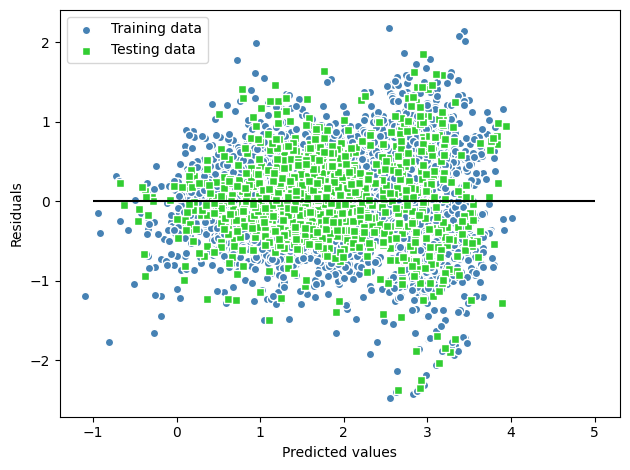

In [27]:
plot_results(y_train,y_train_predicted,y_test,y_predicted)

In [28]:
#plot_results(np.exp(y_train), np.exp(y_train_predicted), np.exp(y_test), np.exp(y_predicted))

Feature importance

In [29]:
feature_importances = lin_reg.coef_
cat_features = []
cat_encoder = full_Pipeline.named_transformers_["cat"]
for idx, column in enumerate(cat):
    cat_features.extend([column+'_'+str(int(val)) for val in cat_encoder.named_steps['encoder'].categories_[idx]])

attributes = num + cat_features

In [30]:
importance = sorted(zip(feature_importances, attributes), reverse=True)
print("Top 10 features")
for i in range(10):
    print(importance[i])
print()
print("Bottom 10 features")
for i in range(1, 11):
    print(importance[-i])
    

Top 10 features
(0.9882046523610957, 'transmission_0')
(0.657480312671828, 'fuel_type_1')
(0.48927599910863595, 'manufacture')
(0.36169869875136235, 'ownership_1')
(0.29124203145847916, 'ownership_2')
(0.21819223745800162, 'fuel_type_2')
(0.16264804094775406, 'ownership_3')
(0.06022786451246962, 'engine')
(0.03739736918619581, 'ownership_0')
(0.01775369667377886, 'ownership_5')

Bottom 10 features
(-0.11253210223126858, 'transmission_1')
(-0.04381748761207728, 'kms_driven')
(0.004932713112258223, 'ownership_4')
(0.01775369667377886, 'ownership_5')
(0.03739736918619581, 'ownership_0')
(0.06022786451246962, 'engine')
(0.16264804094775406, 'ownership_3')
(0.21819223745800162, 'fuel_type_2')
(0.29124203145847916, 'ownership_2')
(0.36169869875136235, 'ownership_1')


Custom Linear Regression

In [31]:
from MyLinearRegression import myLinearRegression

In [32]:
my_lin_reg = myLinearRegression()
my_lin_reg.fit(X_train_t, y_train)

In [33]:
my_y_predicted = my_lin_reg.predict(X_test_t)
my_y_train_predicted = my_lin_reg.predict(X_train_t)

In [34]:
print("My Linear Regression - Training data")
print_metrics(y_train, np.max([my_y_train_predicted, np.zeros_like(my_y_train_predicted)], axis=0))

print("My Linear Regression - Testing data")
print_metrics(y_test, np.max([my_y_predicted, np.zeros_like(my_y_predicted)], axis=0))

My Linear Regression - Training data

    RMSE: 0.5418140632668171
    MAE: 0.41127598197652726
    R2: 0.724533294776172
    
My Linear Regression - Testing data

    RMSE: 0.5392902635730513
    MAE: 0.4041427572414009
    R2: 0.7184941406084522
    


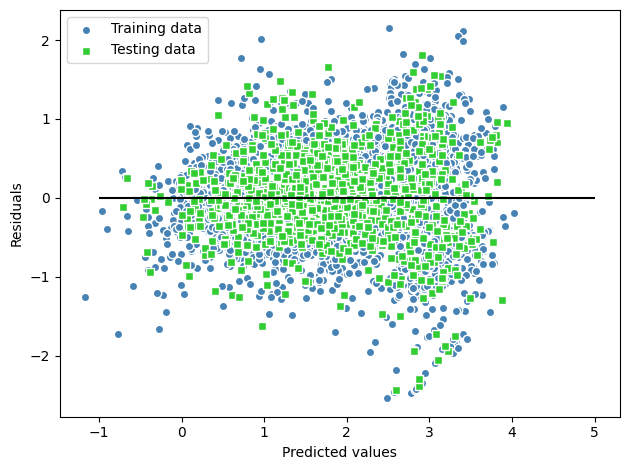

In [35]:
plot_results(y_train,my_y_train_predicted,y_test,my_y_predicted)

Grid Search

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [37]:
pipelineLR = make_pipeline(SGDRegressor())

param_grid_lr = [{
    'sgdregressor__alpha':  np.linspace(0.00001, 0.01, 20),
    'sgdregressor__max_iter' : np.linspace(100,1000,20).astype(int)
}]

gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr)

gsLR = gsLR.fit(X_train_t, y_train)

print('Best score: ',gsLR.best_score_)

params = gsLR.best_params_
print('Best params: ',params)

clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test_t, y_test))

Best score:  0.7221916950755372
Best params:  {'sgdregressor__alpha': 0.0036905263157894744, 'sgdregressor__max_iter': 478}
Test accuracy: 0.721


In [38]:
lin_reg_GridSearch = SGDRegressor(alpha = params['sgdregressor__alpha'],max_iter = params['sgdregressor__max_iter'] ).fit(X_train_t, y_train)

GridSearch_train_y_predicted = lin_reg_GridSearch.predict(X_train_t)
GridSearch_test_y_predicted = lin_reg_GridSearch.predict(X_test_t)

In [39]:
print("Linear Regression Grid Search - Training data")
print_metrics(y_train, np.max([GridSearch_train_y_predicted, np.zeros_like(GridSearch_train_y_predicted)], axis=0))

print("Linear Regression Grid Search - Testing data")
print_metrics(y_test, np.max([GridSearch_test_y_predicted, np.zeros_like(GridSearch_test_y_predicted)], axis=0))

Linear Regression Grid Search - Training data

    RMSE: 0.5422351675107351
    MAE: 0.4116198412360935
    R2: 0.7241049364707949
    
Linear Regression Grid Search - Testing data

    RMSE: 0.5378049567037282
    MAE: 0.4011493920338772
    R2: 0.7200426454518349
    


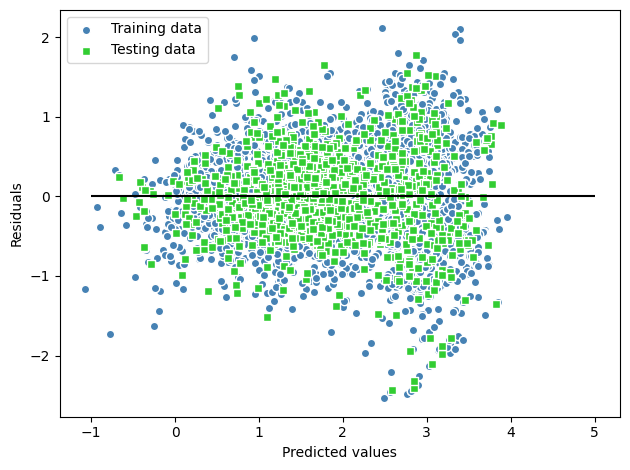

In [40]:
plot_results(y_train,GridSearch_train_y_predicted,y_test,GridSearch_test_y_predicted)

Printing models evaluation (SGDRegressor with and without Grid Search for hyperparameters)

In [41]:
print("Linear Regression - Training data")
print_metrics(y_train, np.max([y_train_predicted, np.zeros_like(y_train_predicted)], axis=0))

print("Linear Regression - Testing data")
print_metrics(y_test, np.max([y_predicted, np.zeros_like(y_predicted)], axis=0))


print("\nLinear Regression Grid Search - Training data")
print_metrics(y_train, np.max([GridSearch_train_y_predicted, np.zeros_like(GridSearch_train_y_predicted)], axis=0))

print("Linear Regression Grid Search - Testing data")
print_metrics(y_test, np.max([GridSearch_test_y_predicted, np.zeros_like(GridSearch_test_y_predicted)], axis=0))

Linear Regression - Training data

    RMSE: 0.5411406635800545
    MAE: 0.4107385373450227
    R2: 0.7252176030313582
    
Linear Regression - Testing data

    RMSE: 0.5374106942856661
    MAE: 0.40145810570586066
    R2: 0.7204529659736632
    

Linear Regression Grid Search - Training data

    RMSE: 0.5422351675107351
    MAE: 0.4116198412360935
    R2: 0.7241049364707949
    
Linear Regression Grid Search - Testing data

    RMSE: 0.5378049567037282
    MAE: 0.4011493920338772
    R2: 0.7200426454518349
    
